In [114]:
from main import VoronoiFacilitySelection 
from main import dot_extract
import numpy as np
from scipy.spatial import Voronoi, voronoi_plot_2d
from sklearn.neighbors import NearestNeighbors

import matplotlib.pyplot as plt
from pprint import pprint


In [2]:
v, e = dot_extract()

In [295]:
V = {"1":[0,0],"2":[2,0],"3":[0,2],"4":[2,2],"5":[1,1]}
V = {"1":np.random.rand(2)*100,"2":np.random.rand(2)*100,"3":np.random.rand(2)*100,"4":np.random.rand(2)*100,"5":np.random.rand(2)*100}
model = VoronoiFacilitySelection(random_state=11,n_cells=4)
vor = Voronoi(list(V.values()))

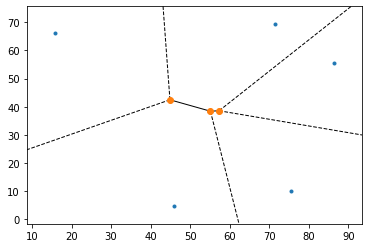

In [296]:
fig = voronoi_plot_2d(vor)

In [297]:
vor.vertices

array([[44.86566891, 42.46188807],
       [57.29980461, 38.5693229 ],
       [55.1013318 , 38.41342763]])

In [298]:
vor.regions

[[2, 0, -1, 1], [2, -1, 0], [-1, 0], [], [1, -1], [2, -1, 1]]

In [299]:
vor.point_region

array([1, 0, 5, 4, 2])

In [300]:
vor.points

array([[45.86885089,  4.87601673],
       [71.30763421, 69.19251786],
       [75.48876313, 10.22922501],
       [86.30269819, 55.68164372],
       [15.77130201, 66.27830914]])

In [301]:
vor.ridge_points

array([[1, 0],
       [1, 4],
       [1, 3],
       [1, 2],
       [0, 4],
       [0, 2],
       [3, 2]], dtype=int32)

In [302]:
vor.ridge_vertices

[[0, 2], [-1, 0], [-1, 1], [1, 2], [-1, 0], [-1, 2], [-1, 1]]

In [303]:
vor.ridge_dict

{(1, 0): [0, 2],
 (1, 4): [-1, 0],
 (1, 3): [-1, 1],
 (1, 2): [1, 2],
 (0, 4): [-1, 0],
 (0, 2): [-1, 2],
 (3, 2): [-1, 1]}

In [304]:
vor.point_region


array([1, 0, 5, 4, 2])

In [305]:
V

{'1': array([45.86885089,  4.87601673]),
 '2': array([71.30763421, 69.19251786]),
 '3': array([75.48876313, 10.22922501]),
 '4': array([86.30269819, 55.68164372]),
 '5': array([15.77130201, 66.27830914])}

In [306]:
v=list(V.values())
v

[array([45.86885089,  4.87601673]),
 array([71.30763421, 69.19251786]),
 array([75.48876313, 10.22922501]),
 array([86.30269819, 55.68164372]),
 array([15.77130201, 66.27830914])]

In [337]:
# this section will be pre-processing
min_x = min(np.array(list(V.values()))[:,0])
min_y = min(np.array(list(V.values()))[:,1])
max_x = max(np.array(list(V.values()))[:,0])
max_y = max(np.array(list(V.values()))[:,1])

min_bound = [min_x,min_y]
max_bound = [max_x,max_y]

# I need to find the minimum, and maximum in the point set
CH_points = np.array([min_bound,[max_bound[0],min_bound[1]],max_bound,[min_bound[0],max_bound[1]]])

CH_segments = np.array([[CH_points[i-1],CH_points[i]] for i in range(len(CH_points))])


In [338]:
# compute distances of centers, with voronoi verticies
for i, point_region in zip(range(len(vor.points)),vor.point_region):
    vor_v_i = vor.regions[point_region]
    points = np.array([vor.vertices[p] for p in vor_v_i if p >= 0])
    center = vor.points[i]
    delta = points - center
    delta_max = delta[np.argmax(np.apply_along_axis(np.linalg.norm,1,delta))]
    
    # check if delta max is bigger than any other distances found thus far for point at index i
    print(delta_max)

    

[-1.00318198 37.58587133]
[-26.4419653 -26.7306298]
[-20.38743133  28.18420262]
[-29.00289358 -17.11232083]
[ 29.0943669  -23.81642107]


In [339]:
# compute distance of centers, with C.H, points

# this section will inside the loop
neigh = NearestNeighbors(n_neighbors=1, radius=0.0000000000001) 
neigh.fit(vor.points)

Y = neigh.kneighbors(CH_points,1,return_distance=False) 

for center_i,CH_p in zip(Y,CH_points):
    center = vor.points[center_i]
    delta = CH_p-center
    
    #check if delta is greater than any other delta of center_i
    print(delta)
    

[[-30.09754888   0.        ]]
[[10.81393506 -5.35320828]]
[[ 0.         13.51087414]]
[[0.         2.91420872]]


In [340]:
# compute distance of centers, with edge intersections

#rotation matrix 90 deg
rot = np.array([[0,-1],[1,0]])


#compute centroid
hull = set()
for points , voronoi_ridge in vor.ridge_dict.items():
    if voronoi_ridge[np.argmin(voronoi_ridge)] < 0:
        hull.add(points[0])
        hull.add(points[1])

hull = np.array([vor.points[i] for i in hull])
centroid = np.sum(hull,axis=0)/hull.shape[0]

print('hull',hull)

for points_index, voronoi_ridge in vor.ridge_dict.items():
    # find the infnite voronoi ridges
    if voronoi_ridge[np.argmin(voronoi_ridge)] >= 0:
        continue
    print("Points Index : ",points_index,"Edge : ", voronoi_ridge)
    p0 = vor.vertices[voronoi_ridge[np.argmax(voronoi_ridge)]]
    p1 = vor.points[points_index[0]]
    p2 = vor.points[points_index[1]]
    
    #bisector
    q = (p1 + p2)/2
    # normal vector of q
    s = (p1-p2)@rot
    # q plus s
    #p_pl_s = p + s
    t1 = np.sign(np.linalg.det(np.hstack((np.array(([p1,p2,q+s])),np.ones((3,1))))))
    t2 = np.sign(np.linalg.det(np.hstack((np.array(([p1,p2,centroid])),np.ones((3,1))))))
    
    # make sure the the edge is pointing outwards from the convex hull
    if t1 == t2:
        s = -s
        
    #original math proof from :
    #https://stackoverflow.com/questions/563198/how-do-you-detect-where-two-line-segments-intersect/565282#565282
    #
    #take the idea of line segment intersection
    # q+ s   p + r
    # \    /
    #  \  /
    #   \/
    #   /\
    #  /  \
    # /    \
    # p     q
    #
    # p + t*r = q + u*s ; where t and u are scalars
    # (p + t*r)xs = (q + u*s)xs
    # pxs + t*rxs = qxs + 0
    # t*rxs = qxs - pxs
    # t = [(q-p)xs]/rxs
    # if t is negaive, then we went left of p, thus did not intersect
    # if |p + tr - p| > |p + r - p| then we have gone past our endpoint c2
    # note, this is also t|r| > |r| -> t > 1
    
    #print('p+s',p+s)
    #print('p',p)
    #print("calculating t")
    for c1, c2 in CH_segments:
        p = c1
        r = c2 - c1

        t = np.cross((q-p),s)/np.cross(r,s)
        u = np.cross((q-p),r)/np.cross(r,s)
        

        # ray q intersects segment p at point p + tr (u cannot b zero, else we go backards, t must be btwn segment)
        if 0 <= t and t <= 1 and u >= 0 and np.cross(r,s) != 0:
            
            #print('p = ',p, ' r = ',r,' p + r = ', p + r)
            #print('q = ',q, ' s = ',s, ' q + s = ', q + s)
            
            #print('r',r)
            #print('s',s)
            #print('cross-product r x s: ',cross)
            #print('q-p',q-p)
            #print('r',r)
            #print('cross-product (q - p) x r',np.cross((q-p),r))
            #print('t',t)
            print('p+t*r',p + t*r)
            #print('u',u)
        
        #print("-----------------")

    


hull [[45.86885089  4.87601673]
 [71.30763421 69.19251786]
 [75.48876313 10.22922501]
 [86.30269819 55.68164372]
 [15.77130201 66.27830914]]
Points Index :  (1, 4) Edge :  [-1, 0]
p+t*r [43.46300814 69.19251786]
Points Index :  (1, 3) Edge :  [-1, 1]
p+t*r [84.89195984 69.19251786]
Points Index :  (0, 4) Edge :  [-1, 0]
p+t*r [15.77130201 28.2007083 ]
Points Index :  (0, 2) Edge :  [-1, 2]
p+t*r [61.16254982  4.87601673]
Points Index :  (3, 2) Edge :  [-1, 1]
p+t*r [86.30269819 31.66902107]


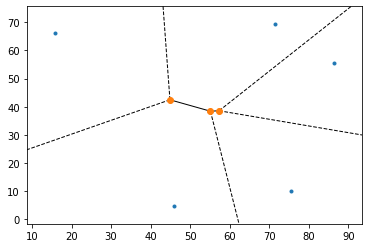

In [341]:
fig = voronoi_plot_2d(vor)

In [321]:
vor.points

array([[45.86885089,  4.87601673],
       [71.30763421, 69.19251786],
       [75.48876313, 10.22922501],
       [86.30269819, 55.68164372],
       [15.77130201, 66.27830914]])

In [322]:


hull = set()
for points , voronoi_ridge in vor.ridge_dict.items():
    if voronoi_ridge[np.argmin(voronoi_ridge)] < 0:
        hull.add(points[0])
        hull.add(points[1])

hull = np.array([vor.points[i] for i in hull])
centroid = np.sum(hull,axis=0)/hull.shape[0]


array([[45.86885089,  4.87601673],
       [71.30763421, 69.19251786],
       [75.48876313, 10.22922501],
       [86.30269819, 55.68164372],
       [15.77130201, 66.27830914]])